<a href="https://colab.research.google.com/github/microprediction/m6/blob/main/notebook_examples/auto_completion_example_more_detail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade git+https://github.com/microprediction/winning.git

In [ ]:
!pip install --upgrade scipy
!pip install array-to-latex

### Fill table of 5-way rank probabilities from "best stock" probabilities

In [3]:
from winning.lattice import skew_normal_density
from winning.lattice_plot import densitiesPlot
from pprint import pprint


We infer 5-way rank probabilities from the probability that a stock will perform the best. 

This method assumes that you believe stocks have the same return distribution (one month hence) up to a translation. Of course this isn't the only assumption that might be applied. See the other notebooks. 




In [4]:
a = 1.0 # Skew parameter 
unit = 0.1 # Lattice step size
density = skew_normal_density(L=100, unit=unit, scale=1.0, loc=0, a=a)
assets = ['Asset '+str(i) for i in range(1,6)]
p = [ 0.25, 0.15, 0.2, 0.22, 0.18 ] # Probability of being lowest return stock

Infer relative location parameters, called "abilities" here


In [7]:
from winning.lattice_calibration import state_price_implied_ability
abilities = state_price_implied_ability(density=density, prices=p, unit=unit)
print(abilities)

[-0.1252758619314367, 0.15478077051750955, -0.00043075891387986826, -0.05180244063169709, 0.05860177767709518]


Plot the offset densities

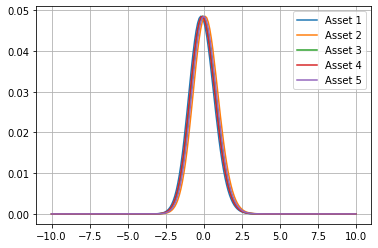

In [8]:
from winning.lattice import densities_from_offsets
densities = densities_from_offsets( density=density, offsets = [abl/unit for abl in abilities])
densitiesPlot(densities=densities,unit=0.1,legend=assets)

In [ ]:
from winning.lattice_copula import gaussian_copula_five
import time 
st = time.time()
rank_probs = gaussian_copula_five(densities, rho=0.0)
print({'elapsed':time.time()-st})


{'elapsed': 1.0733675956726074}


We show the 5-way rank probabilties and check that the probability of a stock being the worst is roughly the same as what we assumed at the outset, at least with rho=0 

In [ ]:
import pandas as pd
index = ['Rank '+str(i) for i in range(1,6)]
df = pd.DataFrame(columns=assets,data=rank_probs, index=index).transpose()
df['p']=p
df['Rank 1 - p'] = df['Rank 1']-df['p']
df

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,p,Rank 1 - p
Asset 1,0.249921,0.217607,0.196883,0.178508,0.157080,0.25,-0.000079
Asset 2,0.150013,0.177024,0.198608,0.221234,0.253121,0.15,0.000013
Asset 3,0.200188,0.202625,0.202135,0.200010,0.195042,0.20,0.000188
Asset 4,0.219905,0.209403,0.200539,0.191319,0.178833,0.22,-0.000095
Asset 5,0.179973,0.193341,0.201834,0.208928,0.215923,0.18,-0.000027


Next we'll assume 25% correlation between the assets (or technically, between auxiliary random N(0,1) variables ... not the assets themselves ... see the paper)


In [ ]:
rank_probs = gaussian_copula_five(densities, rho=0.25)
df = pd.DataFrame(columns=assets,data=rank_probs, index=index).transpose()
df['p']=p
df['Rank 1 - p'] = df['Rank 1']-df['p']
df

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5,p,Rank 1 - p
Asset 1,0.251548,0.218146,0.196772,0.177823,0.155711,0.25,0.001548
Asset 2,0.148556,0.176222,0.198422,0.221803,0.254997,0.15,-0.001444
Asset 3,0.200127,0.202743,0.202264,0.200052,0.194814,0.20,0.000127
Asset 4,0.220472,0.209751,0.200620,0.191076,0.178081,0.22,0.000472
Asset 5,0.179297,0.193138,0.201922,0.209246,0.216397,0.18,-0.000703


That's pretty much the end of the show, although I need a few things below for writeup and comparisons elsewhere. 

You'll notice that this time the probability of the stock being the worst deviates a little more, but is still extremely close. In general the rank probabilities will be largely insensitive to the choice of correlation parameter rho, because this is something of an Urn game and the common factor increases or decreases their absolute probabilities by roughly the same amount. 


In [ ]:
import array_to_latex as a2l
import numpy as np
a2l.to_ltx(np.asarray(rank_probs), frmt = '{:6.3f}', arraytype = 'array')

\begin{array}
   0.252 &   0.149 &   0.200 &   0.220 &   0.179\\
   0.218 &   0.176 &   0.203 &   0.210 &   0.193\\
   0.197 &   0.198 &   0.202 &   0.201 &   0.202\\
   0.178 &   0.222 &   0.200 &   0.191 &   0.209\\
   0.156 &   0.255 &   0.195 &   0.178 &   0.216
\end{array}


In [ ]:
a2l.to_ltx(df, frmt = '{:6.3f}')

\begin{tabular}{lrrrrrrr}
\toprule
     & Rank 1 & Rank 2 & Rank 3 & Rank 4 & Rank 5 & p & Rank 1 - p \\\n\midrule
 Asset 1 &   0.252 &   0.218 &   0.197 &   0.178 &   0.156 &   0.250 &   0.002\\
 Asset 2 &   0.149 &   0.176 &   0.198 &   0.222 &   0.255 &   0.150 & -0.001\\
 Asset 3 &   0.200 &   0.203 &   0.202 &   0.200 &   0.195 &   0.200 &   0.000\\
 Asset 4 &   0.220 &   0.210 &   0.201 &   0.191 &   0.178 &   0.220 &   0.000\\
 Asset 5 &   0.179 &   0.193 &   0.202 &   0.209 &   0.216 &   0.180 & -0.001\\
\bottomrule
\end{tabular}


In [ ]:
df_not = df.copy()
for i in [2,3,4,5]:
  df_not['Rank '+str(i)]=['?']*5
del df_not['p']
del df_not['Rank 1 - p']
df_not

,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5
Asset 1,0.251548,?,?,?,?
Asset 2,0.148556,?,?,?,?
Asset 3,0.200127,?,?,?,?
Asset 4,0.220472,?,?,?,?
Asset 5,0.179297,?,?,?,?


In [ ]:
a2l.to_ltx(df_not)

\begin{tabular}{lrrrrr}
\toprule
     & Rank 1 & Rank 2 & Rank 3 & Rank 4 & Rank 5 \\\n\midrule
 Asset 1 &  0.25 &  ? &  ? &  ? &  ?\\
 Asset 2 &  0.15 &  ? &  ? &  ? &  ?\\
 Asset 3 &  0.20 &  ? &  ? &  ? &  ?\\
 Asset 4 &  0.22 &  ? &  ? &  ? &  ?\\
 Asset 5 &  0.18 &  ? &  ? &  ? &  ?\\
\bottomrule
\end{tabular}


Now adding some more output by request...

In [9]:
pprint(densities)

[array([1.81291556e-40, 9.74230351e-40, 6.06599057e-39, 3.70301914e-38,
       2.21628614e-37, 1.30050756e-36, 7.48201656e-36, 4.22031406e-35,
       2.33395684e-34, 1.26550677e-33, 6.72761941e-33, 3.50659313e-32,
       1.79200051e-31, 8.97886571e-31, 4.41100213e-30, 2.12465000e-29,
       1.00339932e-28, 4.64620615e-28, 2.10942189e-27, 9.39011286e-27,
       4.09847899e-26, 1.75396673e-25, 7.35985051e-25, 3.02808431e-24,
       1.22157645e-23, 4.83202896e-23, 1.87411883e-22, 7.12731670e-22,
       2.65777995e-21, 9.71804256e-21, 3.48424157e-20, 1.22492746e-19,
       4.22268034e-19, 1.42739751e-18, 4.73133657e-18, 1.53783003e-17,
       4.90142030e-17, 1.53189264e-16, 4.69495345e-16, 1.41102523e-15,
       4.15855936e-15, 1.20187676e-14, 3.40635832e-14, 9.46757421e-14,
       2.58053610e-13, 6.89777524e-13, 1.80817846e-12, 4.64849328e-12,
       1.17199984e-11, 2.89796651e-11, 7.02774444e-11, 1.67148306e-10,
       3.89904618e-10, 8.92056720e-10, 2.00175966e-09, 4.40580076e-09,
     